In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import MDAnalysis as md
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sns
import glob
import cv2

In [2]:
folders = ['.', 'MC3H', 'MC3H_MC3_10_90', 'MC3H_MC3_50_50', 'MC3H_MC3_90_10',\
           'MC3_CHOL_56.5_34.5',\
           'MC3H_RNA', 'MC3H_MC3_CHOL_RNA', 'MC3H_MC3_CHOL_70_5_20', 'MC3H_MC3_CHOL_5_70_25_RNA',\
           'MC3H_MC3_CHOL_53_5_42_RNA']

fold_name = {'.' : 'MC3_noRNA',
             'MC3H' : 'MC3H_noRNA',
             'MC3H_MC3_50_50': 'MC3H_MC3_50_50_noRNA',
             'MC3H_MC3_90_10': 'MC3H_MC3_90_10_noRNA',
             'MC3H_MC3_10_90':'MC3H_MC3_10_90_noRNA',
             'MC3_CHOL_56.5_34.5' : 'MC3_CHOL_56.5_34.5',
             'MC3H_RNA' : 'MC3H_RNA',
             'MC3H_MC3_CHOL_RNA':'MC3H_MC3_CHOL_RNA',
             'MC3H_MC3_CHOL_70_5_20': 'MC3H_MC3_CHOL_70_5_25',
             'MC3H_MC3_CHOL_5_70_25_RNA':'MC3H_MC3_CHOL_5_70_25_RNA',
             'MC3H_MC3_CHOL_53_5_42_RNA':'MC3H_MC3_CHOL_53_5_42_RNA',
            }

# Tesselation plots

In [3]:
def plot (system, name):
    u = md.Universe(f'{system}/p.pdb')

    cog = u.select_atoms(f'resname MC3 MC3H CHOL').center_of_geometry()[2]
    lipid_selection = u.select_atoms(f'name CN GLA ROH R1 and prop z > {cog}')

    # Get the lipid coordinates and resnames for each frame in the trajectory
    lipid_coordinates = []
    lipid_resnames = []
    for ts in u.trajectory:
        lipid_coordinates.append(lipid_selection.positions)
        lipid_resnames.append(lipid_selection.resnames)

    lipid_coordinates = np.array(lipid_coordinates)[:, :, :2]  # Keep only the first two dimensions
    lipid_resnames = np.array(lipid_resnames)

    # Compute the Voronoi diagram of the lipid coordinates
    vor = Voronoi(lipid_coordinates[-1])  # Use only the last frame for Voronoi diagram

    # Get the unique resname values
    resname_list = np.unique(lipid_resnames)

    # Create a dictionary to map resname to color
    #color_map = {resname: plt.cm.Set1(i) for i, resname in enumerate(resname_list)}
    color_map = {'MC3': '#1b9e77',
    'CHOL':'#d95f02',
    'MC3H':'#7570b3'}
    
    # Plot the Voronoi diagram with color-filled bins
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, show_points=False)

    # Color-fill each bin based on the resname
    for region_id, region in enumerate(vor.regions):
        if -1 not in region and region and region_id < len(lipid_resnames[-1]):
            polygon = [vor.vertices[i] for i in region]
            resname = lipid_resnames[-1][region_id]
            ax.fill(*zip(*polygon), facecolor=color_map[resname])

    # Set the limits of the plot based on the lipid coordinates
    ax.set_xlim(lipid_coordinates[:, :, 0].min() - 1, lipid_coordinates[:, :, 0].max() + 1)
    ax.set_ylim(lipid_coordinates[:, :, 1].min() - 1, lipid_coordinates[:, :, 1].max() + 1)

    # Set aspect ratio to equal
    ax.set_aspect('equal')

    # Create a legend for the color map
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color_map[resname]) for resname in resname_list]
    labels = resname_list

    # Move the legend outside of the plot using bbox_to_anchor
    legend = ax.legend(handles, labels, title='Resname', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Adjust the plot layout to make room for the legend
    plt.subplots_adjust(right=0.75)

    plt.savefig(f'/scratch/kmzh811/kmzh811/RNA_MC3_monolayers/RESULTS/{name}_tess.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    return

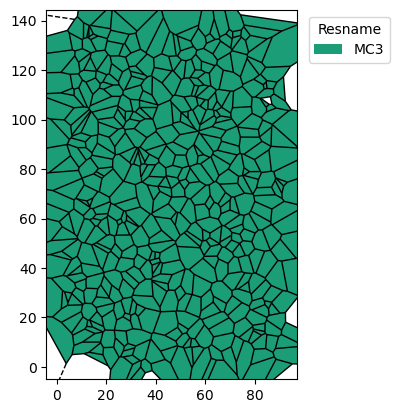

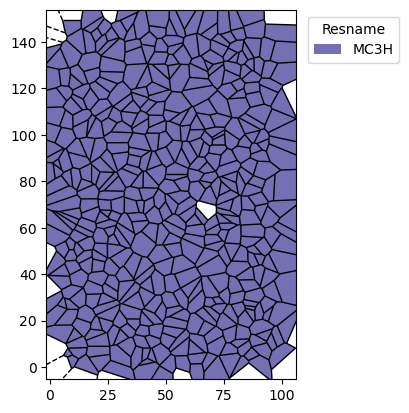

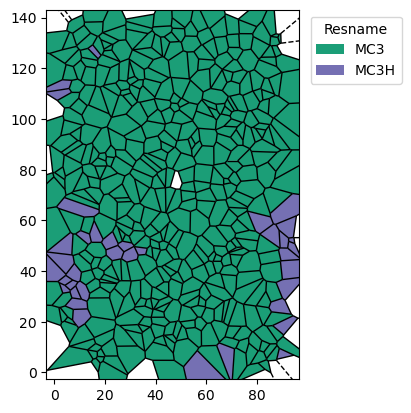

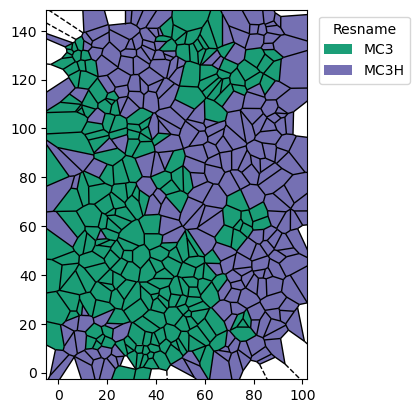

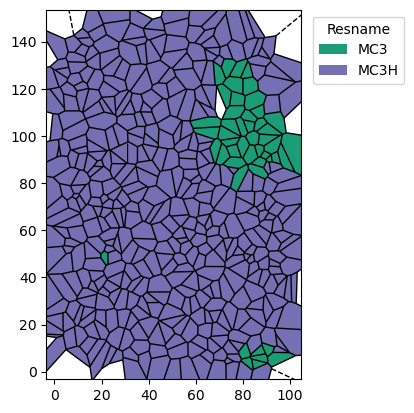

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


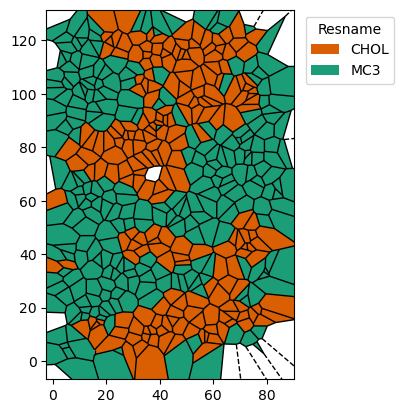

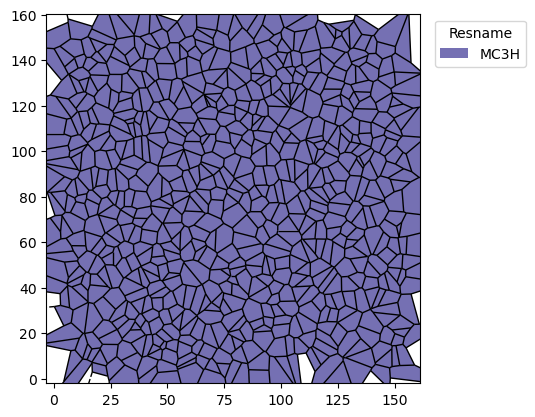

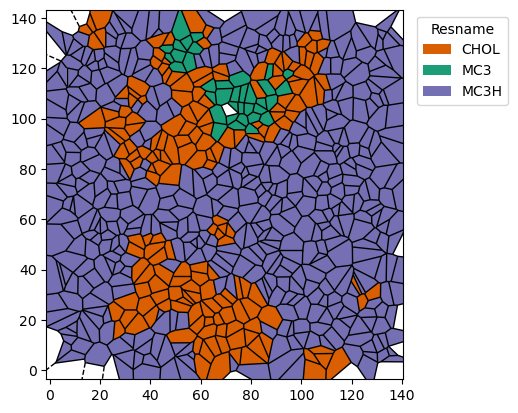

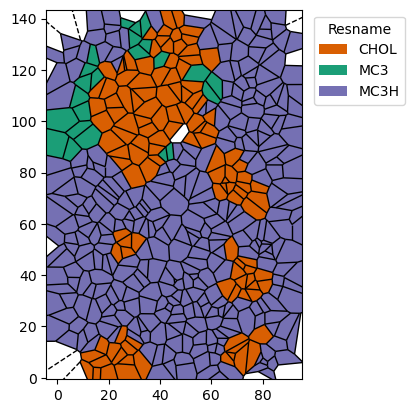

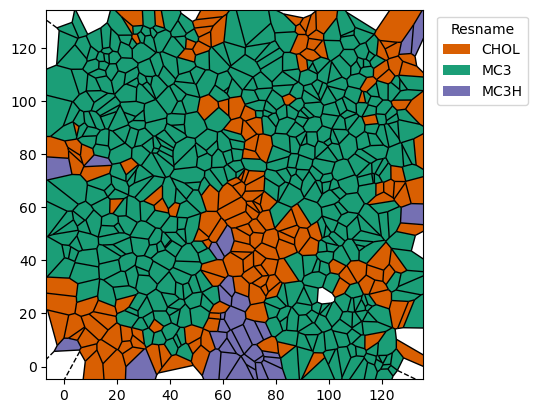

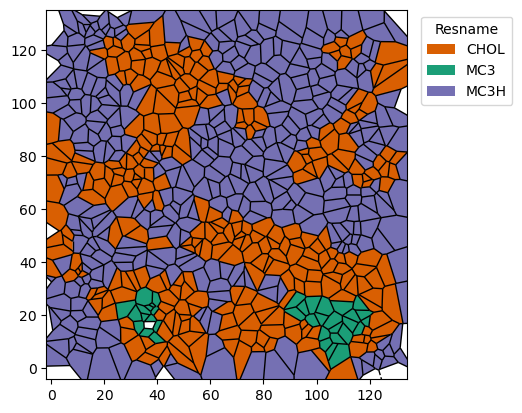

In [5]:
for folder in folders:
    plot(folder, fold_name[folder])

# Enrichment and depletion

In [6]:
def DE (system, name):
    u = md.Universe(f'{system}/p.pdb',f'{system}/p_whole.xtc' )
    lipid_types = np.unique(u.select_atoms('all and not name NA CL W and not resname A').resnames)

    from lipyphilic.lib.neighbours import Neighbours

    # Find neighbouring lipids
    neighbours = Neighbours(
      universe=u,
      lipid_sel="name GLA ROH",
      cutoff=7.0 #was 12 before
    )

    neighbours.run(start=None, stop=None, step=None)

    counts, enrichment = neighbours.count_neighbours(return_enrichment=True)

    # Extract the enrichment value into a two-dimensional NumPy array
    enrichment_values = enrichment.groupby("Label")[enrichment.columns[2:]].mean().values

    # Extract the species residue names to label our heatmap
    labels = np.asarray([column.strip("fe") for column in enrichment.columns if column.startswith("fe")])

#     # There is an enrichment value for each species around each other species
#     enrichment_values.shape

    np.save(f'/scratch/kmzh811/kmzh811/RNA_MC3_monolayers/RESULTS/{name}_DE_values.npy', enrichment_values)

    # Create a figure 
    plt.figure(figsize=(8, 8))
    sns.set({"font.size": 18}) #15 before

    sns.heatmap(
        enrichment_values,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0, vmax=3, center=1,
        annot=False, fmt=".1f",
        square=True,
        cmap="RdBu",
        cbar=True,
        cbar_kws={"label": "Enrichment", "aspect":100, "shrink": 0.863, "pad": 0.01}
    )

    plt.xlabel("Neighbour")
    plt.ylabel("Reference")
    plt.savefig(f'/scratch/kmzh811/kmzh811/RNA_MC3_monolayers/RESULTS/{name}_DE.png', dpi=300, bbox_inches='tight')
    plt.show()
    return

  0%|          | 0/2059 [00:00<?, ?it/s]

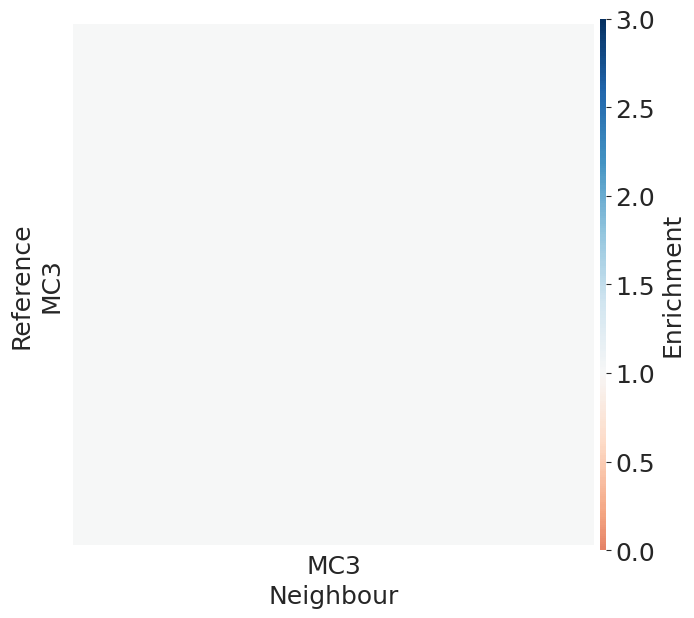

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/5001 [00:00<?, ?it/s]

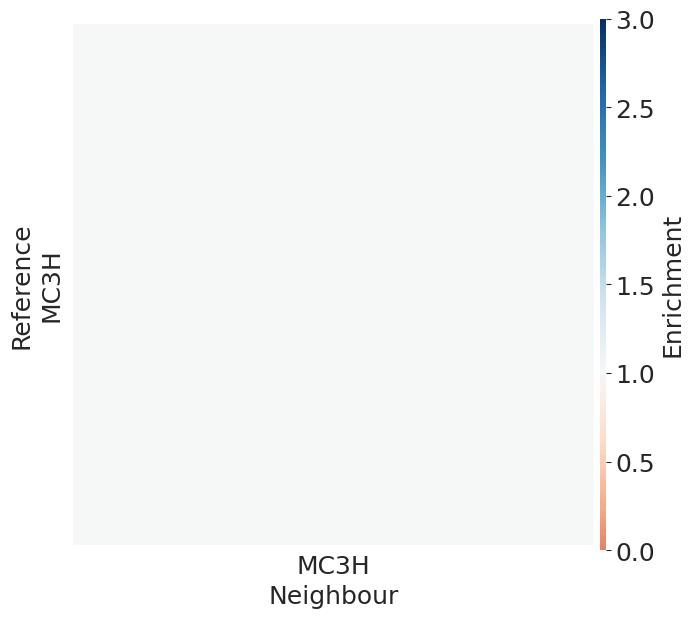

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/1057 [00:00<?, ?it/s]

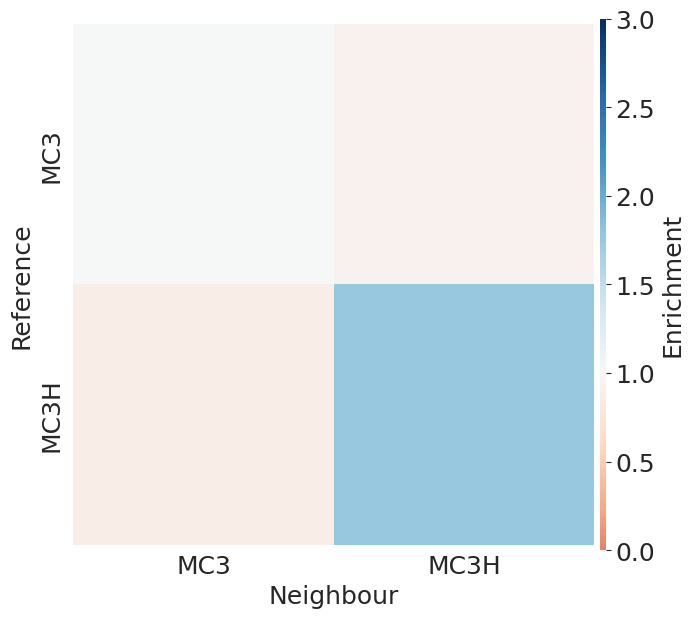

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/591 [00:00<?, ?it/s]

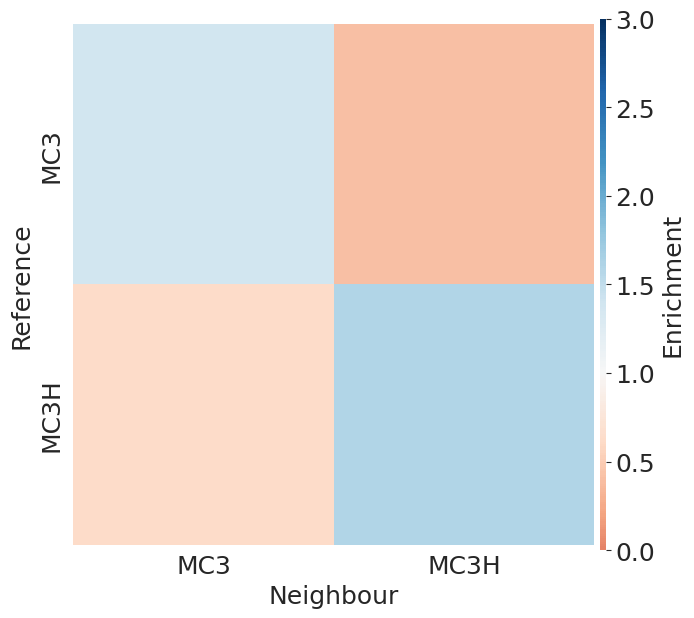

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/5001 [00:00<?, ?it/s]

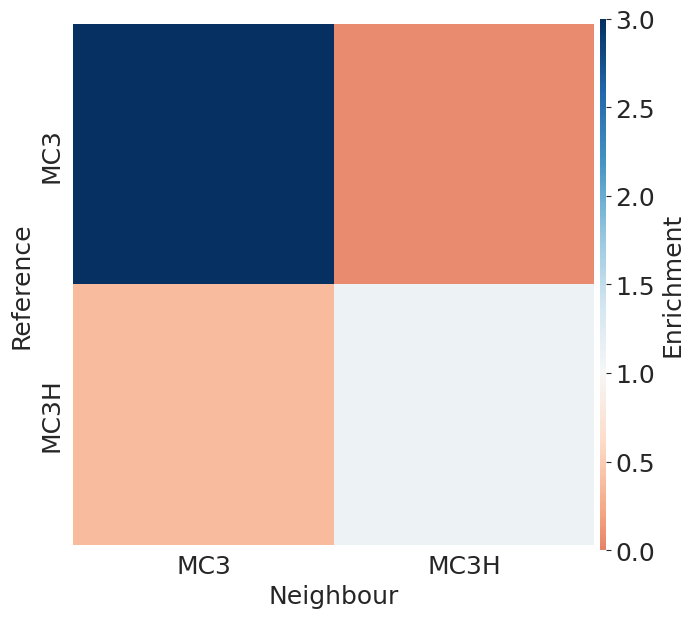

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess 

  0%|          | 0/5001 [00:00<?, ?it/s]

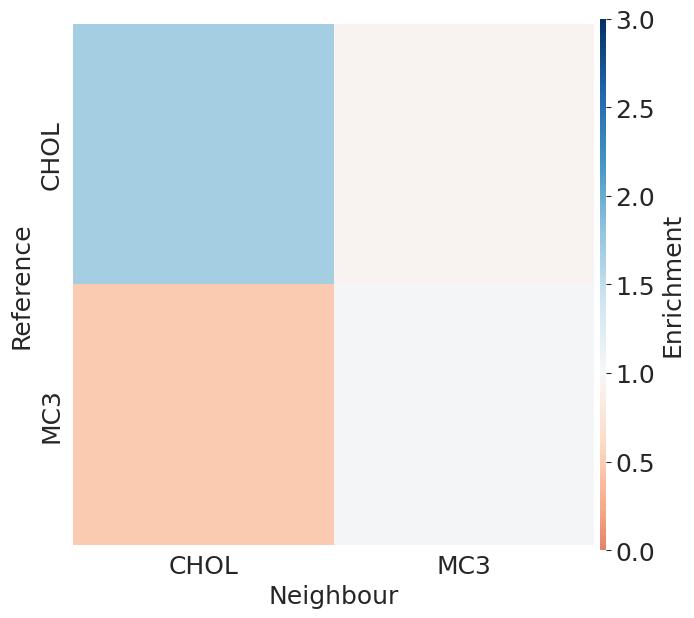

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/5001 [00:00<?, ?it/s]

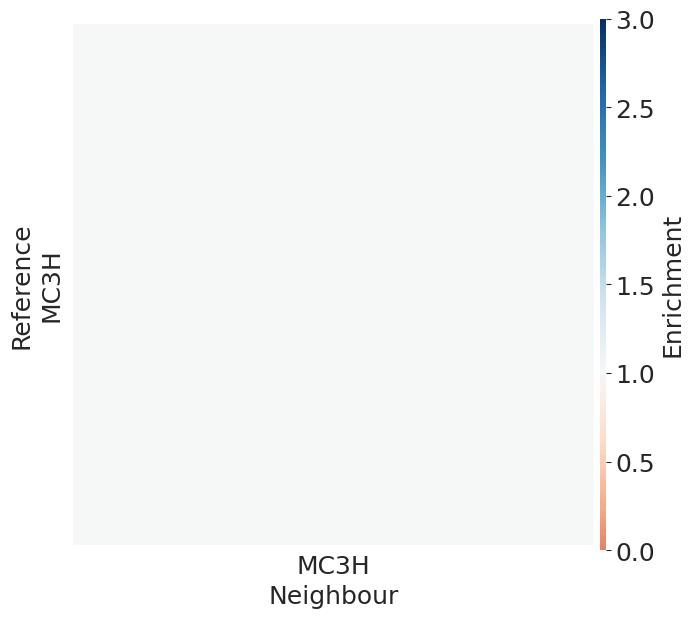

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess 

  0%|          | 0/5001 [00:00<?, ?it/s]

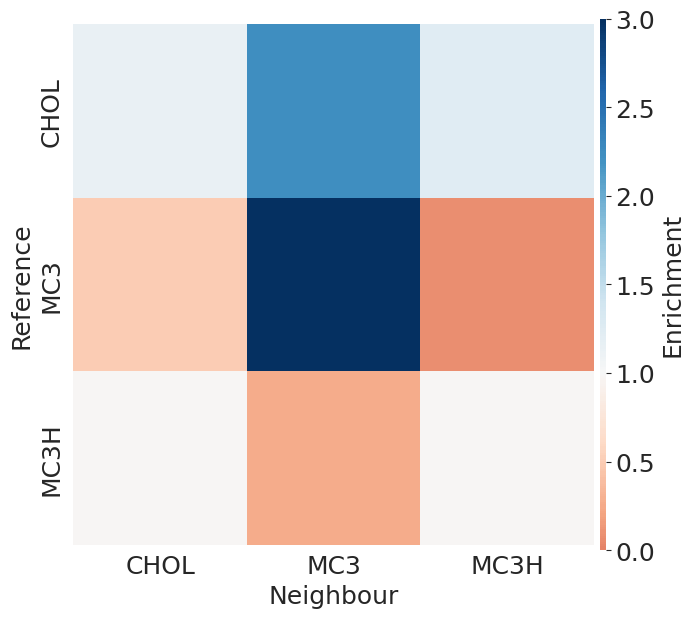

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess 

  0%|          | 0/5001 [00:00<?, ?it/s]

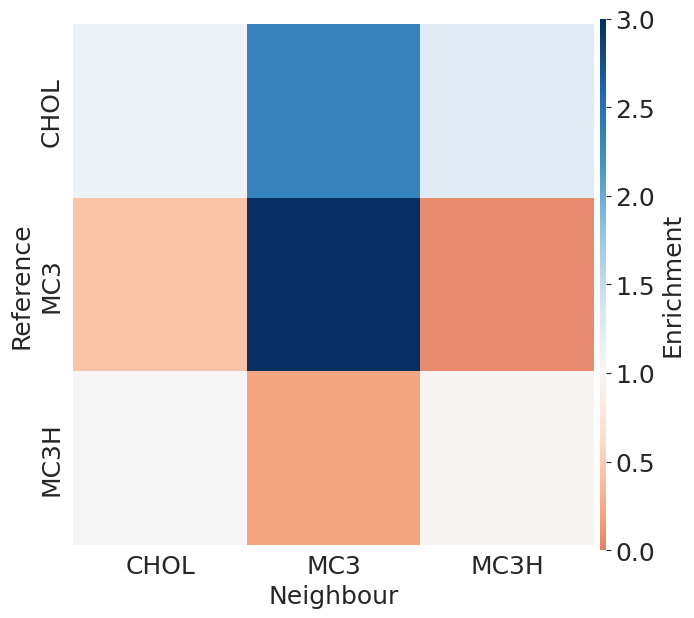

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess 

  0%|          | 0/4938 [00:00<?, ?it/s]

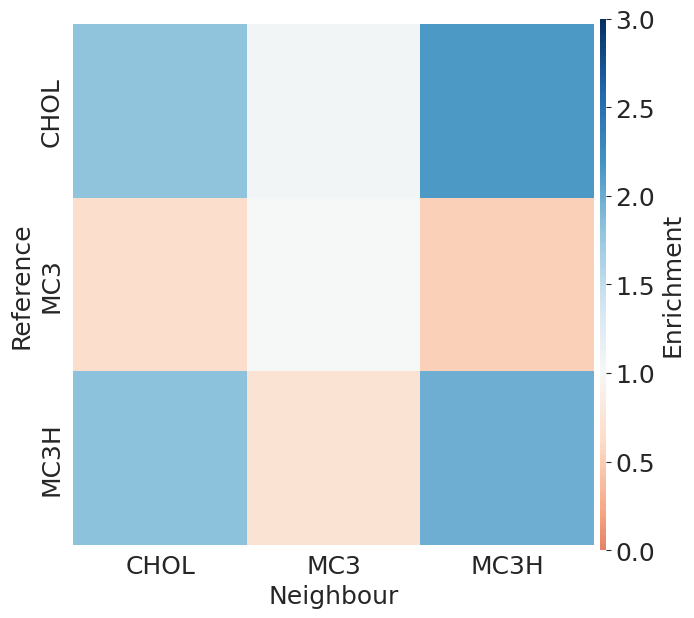

/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess 

  0%|          | 0/5001 [00:00<?, ?it/s]

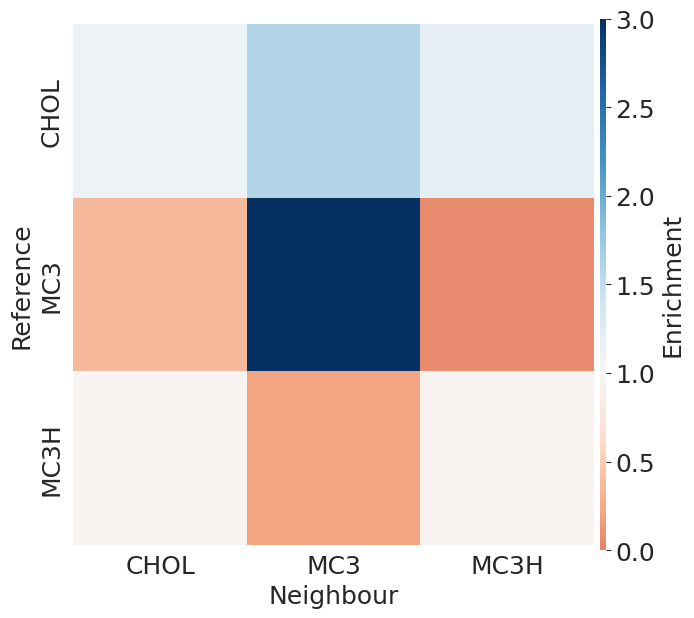

In [7]:
for folder in folders:
    DE(folder, fold_name[folder])

# Combine plots into two figures

In [9]:
out_put_dir_main = "/scratch/kmzh811/kmzh811/RNA_MC3_monolayers"

#### without RNA

In [37]:
folders = [ 'MC3H_MC3_10_90', 'MC3H_MC3_50_50', 'MC3H_MC3_90_10',\
             'MC3H_MC3_CHOL_70_5_20', 'MC3_CHOL_56.5_34.5']

In [38]:
png_files = []
for folder in folders:
    name = fold_name[folder]
    png_files.append(f'{out_put_dir_main}/RESULTS/{name}_tess.png')
    png_files.append(f'{out_put_dir_main}/RESULTS/{name}_DE.png')

In [42]:
len(png_files)/4

2.5

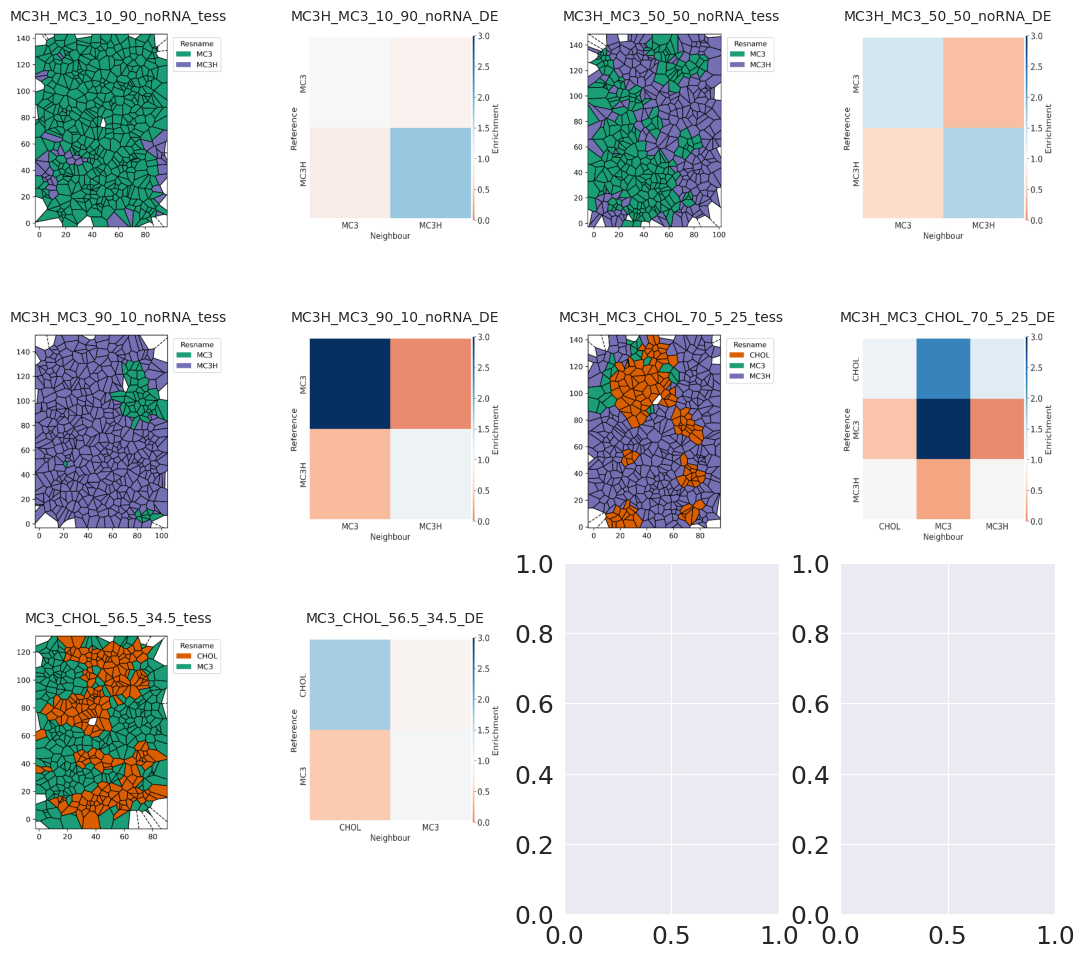

In [48]:
# Define the desired width and height for the images
desired_width = 500
desired_height = 500

# Calculate the number of rows and columns based on the number of PNG files
num_files = len(png_files)
# num_rows = int((num_files + 1) / 5)  # Round up to the nearest integer
# num_cols = int(3)
num_rows = int(3)
num_cols = int(4)

# Create a figure with the calculated grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through the PNG files and plot them
for i, file in enumerate(png_files):
    name = file.split('/')[-1].strip('.png')
    # Read the image using OpenCV
    img = cv2.imread(file)

    # Convert the image to RGB format for plotting with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of non-white regions
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the bounding rectangle for the contour with the largest area
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Crop the image based on the bounding rectangle
    cropped_img = img_rgb[y:y+h, x:x+w]

    # Resize the cropped image to the desired width and height
    resized_img = cv2.resize(cropped_img, (desired_width, desired_height))

    # Plot the resized image on the corresponding axis
    axes[i].imshow(resized_img)
    axes[i].axis("off")

    # Set the title for each subplot
    axes[i].set_title(f"{name}", fontsize=10)

# Adjust the spacing between subplots
plt.tight_layout(pad=0) #0.3

# Reduce the margins of the figure
#plt.subplots_adjust(top=0.95, bottom=0.05, left=0.03, right=0.97)
plt.subplots_adjust(top=0.55, bottom=0.02, left=0.03, right=0.9)

# Display the figure
plt.savefig(f'{out_put_dir_main}/RESULTS/Combined_DE_noRNA.png', dpi=300)
plt.show()


#### With RNA

In [70]:
folders = ['MC3H_RNA', 'MC3H_MC3_CHOL_RNA', 'MC3H_MC3_CHOL_5_70_25_RNA',\
           'MC3H_MC3_CHOL_53_5_42_RNA']

In [71]:
png_files = []
for folder in folders:
    name = fold_name[folder]
    png_files.append(f'{out_put_dir_main}/RESULTS/{name}_tess.png')
    png_files.append(f'{out_put_dir_main}/RESULTS/{name}_DE.png')

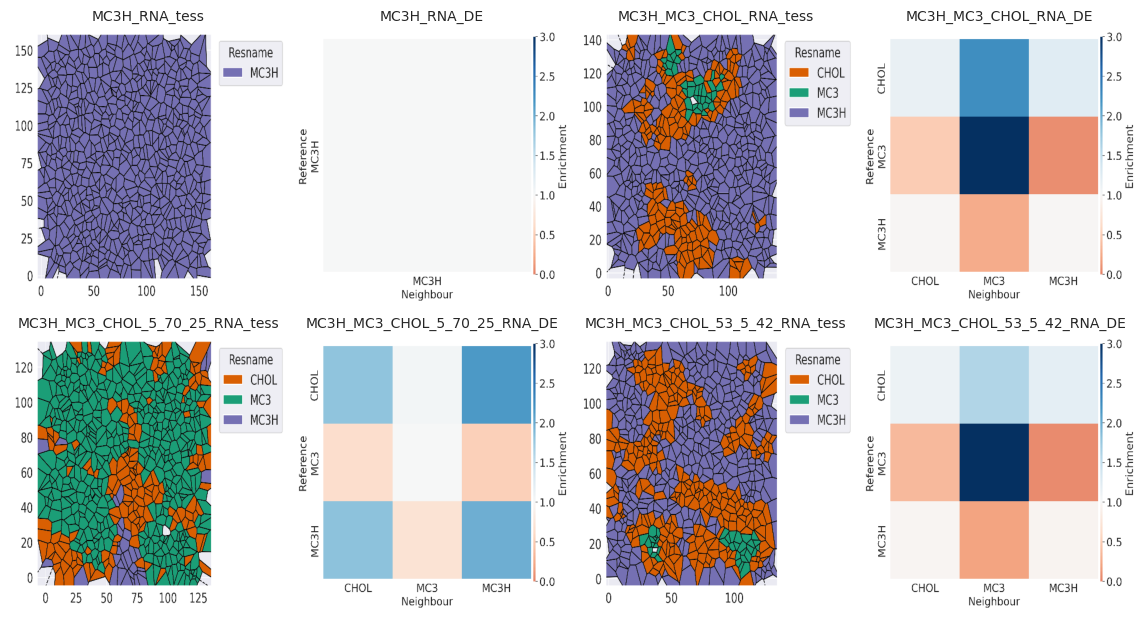

In [72]:
# Define the desired width and height for the images
desired_width = 500
desired_height = 500

# Calculate the number of rows and columns based on the number of PNG files
num_files = len(png_files)
num_rows = (num_files + 1) // 4  # Round up to the nearest integer
num_cols = 4

# Create a figure with the calculated grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through the PNG files and plot them
for i, file in enumerate(png_files):
    name = file.split('/')[-1].strip('.png')
    # Read the image using OpenCV
    img = cv2.imread(file)

    # Convert the image to RGB format for plotting with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of non-white regions
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the bounding rectangle for the contour with the largest area
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Crop the image based on the bounding rectangle
    cropped_img = img_rgb[y:y+h, x:x+w]

    # Resize the cropped image to the desired width and height
    resized_img = cv2.resize(cropped_img, (desired_width, desired_height))

    # Plot the resized image on the corresponding axis
    axes[i].imshow(resized_img)
    axes[i].axis("off")

    # Set the title for each subplot
    axes[i].set_title(f"{name}", fontsize=10)

# Adjust the spacing between subplots
plt.tight_layout(pad=0.3)

# Reduce the margins of the figure
#plt.subplots_adjust(top=0.95, bottom=0.05, left=0.03, right=0.97)
plt.subplots_adjust(top=0.65, bottom=0.04, left=0.03, right=0.97)

# Display the figure
plt.savefig(f'{out_put_dir_main}/RESULTS/Combined_DE_RNA.png', dpi=300)
plt.show()
